In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [3]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [4]:
df = pd.read_csv('air_dataset.csv')

In [5]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
class_name = 'weekend'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,PT08_feat,weekend
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,1186.50,0
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,1148.75,0
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,1024.50,0
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,1015.00,0
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,883.25,0


In [7]:
df[class_name].value_counts()

0    6669
1    2688
Name: weekend, dtype: int64

In [8]:
df[class_name].value_counts(1)

0    0.712728
1    0.287272
Name: weekend, dtype: float64

In [9]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 2390, replace=False)

In [10]:
len(df), len(rows2remove)

(9357, 2390)

In [11]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))

6967


In [12]:
print('Dataset shape %s' % Counter(df2[class_name]))

Dataset shape Counter({0: 6669, 1: 298})


In [13]:
df2[class_name].value_counts(1)

0    0.957227
1    0.042773
Name: weekend, dtype: float64

In [14]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [17]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1], dtype=int64), array([4667,  209], dtype=int64)),
 (array([0, 1], dtype=int64), array([2002,   89], dtype=int64)))

In [18]:
parameters = {'n_neighbors': np.arange(1, 101, 1), 'weights':['uniform', 'distance']}

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.4s finished


Accuracy 0.9579148732663797
F1-score [0.97848411 0.04347826]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2002
           1       0.67      0.02      0.04        89

    accuracy                           0.96      2091
   macro avg       0.81      0.51      0.51      2091
weighted avg       0.95      0.96      0.94      2091



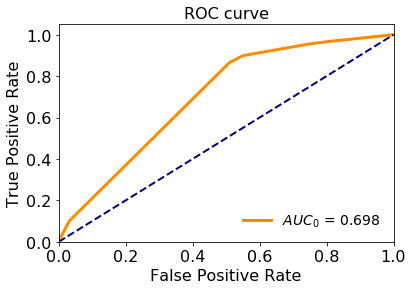

[[2001    1]
 [  87    2]]


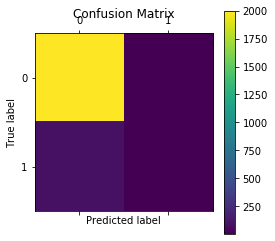





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.1min finished




Accuracy 0.9579148732663797
F1-score [0.97849462 0.02222222]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2002
           1       1.00      0.01      0.02        89

    accuracy                           0.96      2091
   macro avg       0.98      0.51      0.50      2091
weighted avg       0.96      0.96      0.94      2091



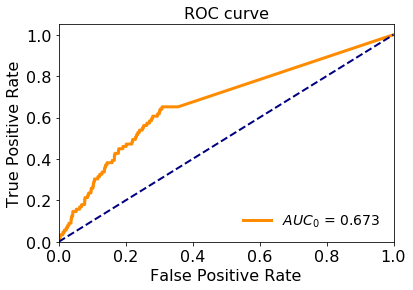

[[2002    0]
 [  88    1]]


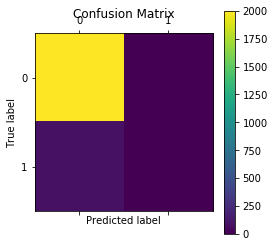

In [19]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_train, y_train)
best = grid_dt.best_estimator_

best.fit(X_train, y_train)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_train, y_train)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
#predice la classe maggiore correttamente

[[2001    1]
 [  87    2]]


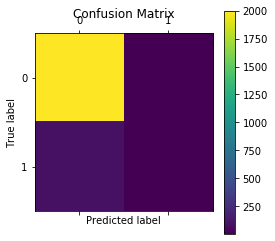

In [21]:
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Undersampling

### RandomUndersampling

In [22]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 209, 1: 209})


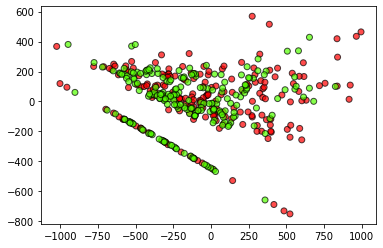

In [23]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished


Accuracy 0.5480631276901005
F1-score [0.6976     0.10596026]
              precision    recall  f1-score   support

           0       0.97      0.54      0.70      2002
           1       0.06      0.63      0.11        89

    accuracy                           0.55      2091
   macro avg       0.51      0.59      0.40      2091
weighted avg       0.93      0.55      0.67      2091



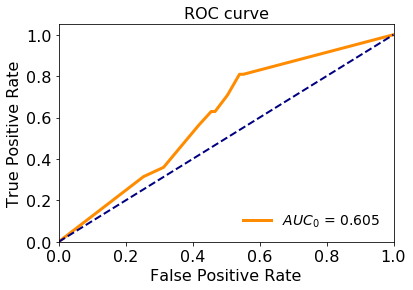

[[1090  912]
 [  33   56]]


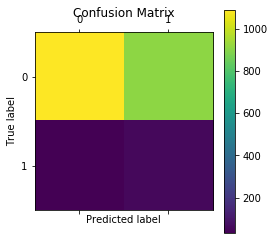





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   13.4s finished




Accuracy 0.5753228120516499
F1-score [0.72040302 0.11729622]
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      2002
           1       0.06      0.66      0.12        89

    accuracy                           0.58      2091
   macro avg       0.52      0.62      0.42      2091
weighted avg       0.94      0.58      0.69      2091



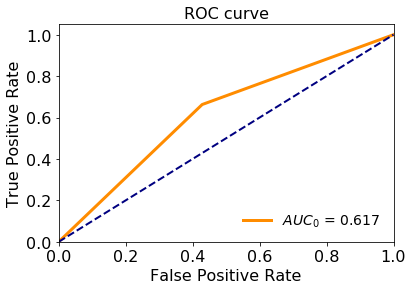

[[1144  858]
 [  30   59]]


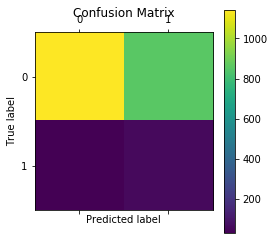

In [24]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
#PREDICE COMUNQUE CORRETTAMENTE LA CLASSE ZERO MA MAI LA 1

### CondensedNearestNeighbour

In [26]:
cnn = CondensedNearestNeighbour(sampling_strategy = "not minority", random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 748, 1: 209})


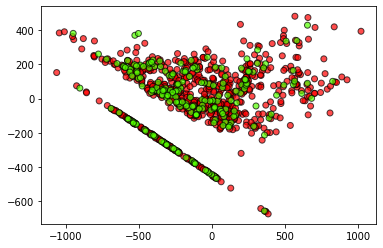

In [27]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

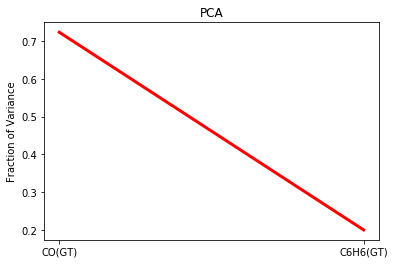

In [28]:
plt.plot(pca.explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(2), df.columns)
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.6s finished


Accuracy 0.9196556671449068
F1-score [0.95797899 0.08695652]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2002
           1       0.08      0.09      0.09        89

    accuracy                           0.92      2091
   macro avg       0.52      0.52      0.52      2091
weighted avg       0.92      0.92      0.92      2091



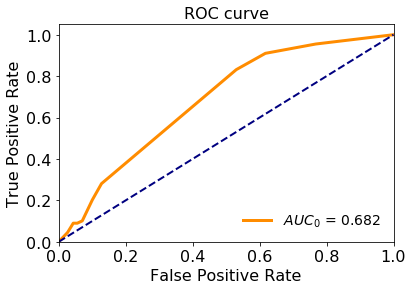

[[1915   87]
 [  81    8]]


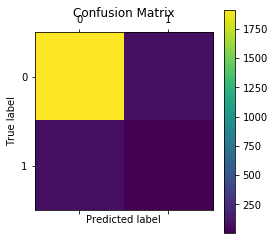





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   14.0s finished




Accuracy 0.9574366331898613
F1-score [0.97825556 0.        ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2002
           1       0.00      0.00      0.00        89

    accuracy                           0.96      2091
   macro avg       0.48      0.50      0.49      2091
weighted avg       0.92      0.96      0.94      2091



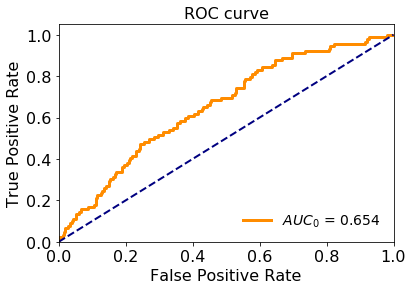

[[2002    0]
 [  89    0]]


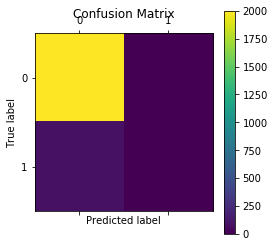

In [29]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Oversampling

In [30]:
df[class_name].value_counts()

0    6669
1    2688
Name: weekend, dtype: int64

In [31]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4667, 1: 4667})


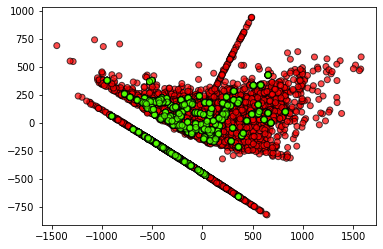

In [32]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

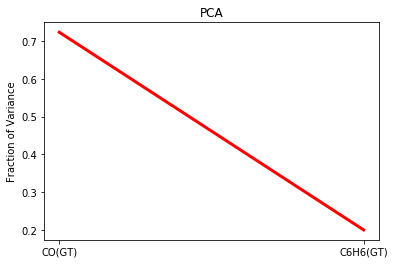

In [33]:
plt.plot(pca.explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(2), df.columns)
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.8s finished


Accuracy 0.8015303682448589
F1-score [0.88780752 0.14078675]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      2002
           1       0.09      0.38      0.14        89

    accuracy                           0.80      2091
   macro avg       0.53      0.60      0.51      2091
weighted avg       0.93      0.80      0.86      2091



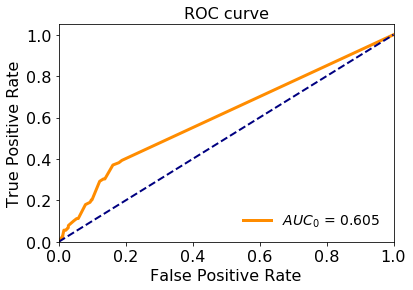

[[1642  360]
 [  55   34]]


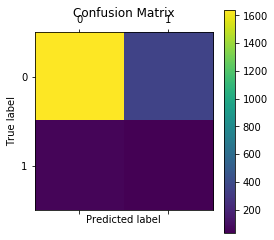





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.1min finished




Accuracy 0.9335246293639407
F1-score [0.96548299 0.10322581]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2002
           1       0.12      0.09      0.10        89

    accuracy                           0.93      2091
   macro avg       0.54      0.53      0.53      2091
weighted avg       0.92      0.93      0.93      2091



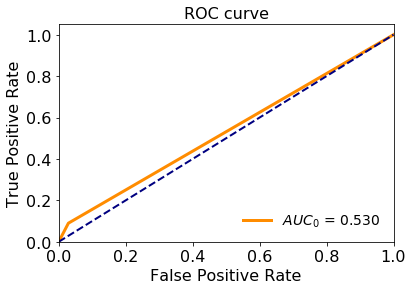

[[1944   58]
 [  81    8]]


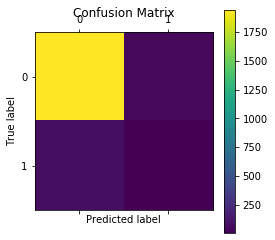

In [34]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### SMOTE

In [35]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4667, 1: 4667})


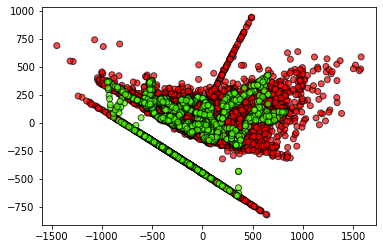

In [36]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

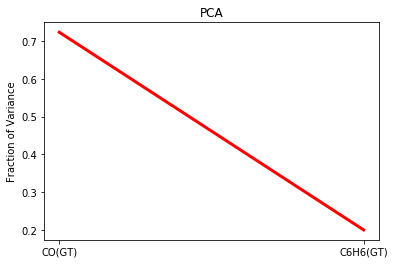

In [37]:
plt.plot(pca.explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(2), df.columns)
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.5s finished


Accuracy 0.741272118603539
F1-score [0.84833193 0.1203252 ]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      2002
           1       0.07      0.42      0.12        89

    accuracy                           0.74      2091
   macro avg       0.52      0.59      0.48      2091
weighted avg       0.93      0.74      0.82      2091



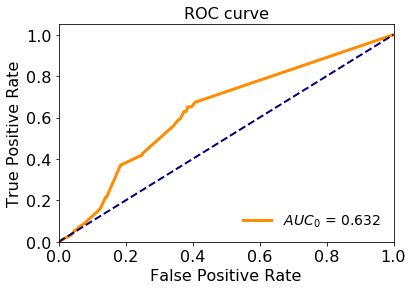

[[1513  489]
 [  52   37]]


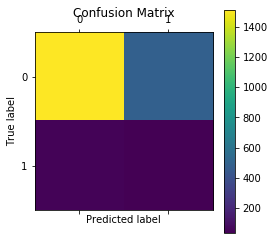





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.1min finished




Accuracy 0.8632233381157342
F1-score [0.92552083 0.16374269]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2002
           1       0.11      0.31      0.16        89

    accuracy                           0.86      2091
   macro avg       0.54      0.60      0.54      2091
weighted avg       0.93      0.86      0.89      2091



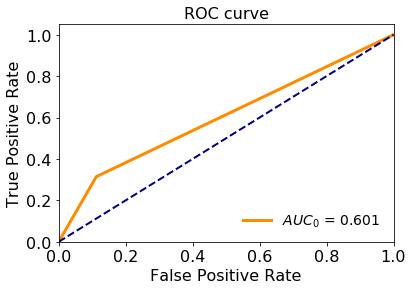

[[1777  225]
 [  61   28]]


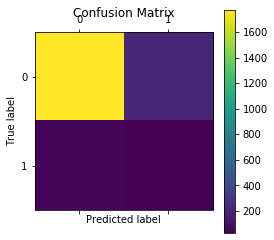

In [38]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# CLASSE 1

In [39]:
df = pd.read_csv('air_dataset.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [40]:
class_name = 'weekend'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,PT08_feat,weekend
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,1186.50,0
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,1148.75,0
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,1024.50,0
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,1015.00,0
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,883.25,0


In [41]:
df[class_name].value_counts()

0    6669
1    2688
Name: weekend, dtype: int64

In [42]:
df[class_name].value_counts(1)

0    0.712728
1    0.287272
Name: weekend, dtype: float64

In [43]:
rows2remove = np.random.choice(df[df[class_name] == 0].index, 6562, replace=False)

In [44]:
len(df), len(rows2remove)

(9357, 6562)

In [45]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))

2795


In [46]:
df2[class_name].value_counts(1)

1    0.961717
0    0.038283
Name: weekend, dtype: float64

In [47]:
print('Dataset shape %s' % Counter(df2[class_name]))

Dataset shape Counter({1: 2688, 0: 107})


In [48]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [49]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1], dtype=int64), array([  75, 1881], dtype=int64)),
 (array([0, 1], dtype=int64), array([ 32, 807], dtype=int64)))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.1s finished


Accuracy 0.9582836710369488
F1-score [0.05405405 0.97867154]
              precision    recall  f1-score   support

           0       0.20      0.03      0.05        32
           1       0.96      1.00      0.98       807

    accuracy                           0.96       839
   macro avg       0.58      0.51      0.52       839
weighted avg       0.93      0.96      0.94       839



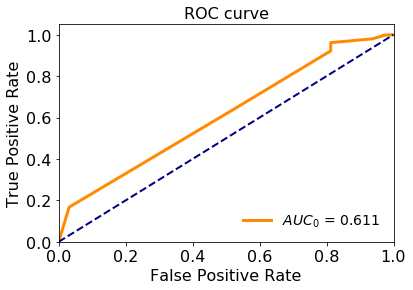

[[  1  31]
 [  4 803]]


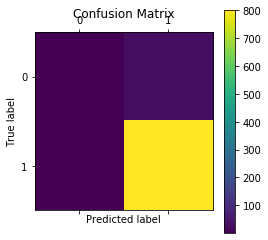





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   24.5s finished




Accuracy 0.9618593563766389
F1-score [0.         0.98055893]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.96      1.00      0.98       807

    accuracy                           0.96       839
   macro avg       0.48      0.50      0.49       839
weighted avg       0.93      0.96      0.94       839



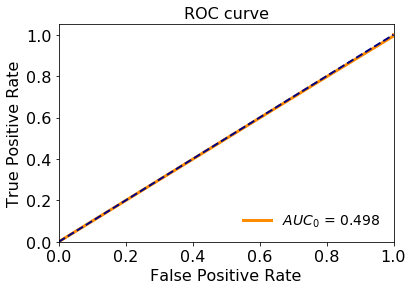

[[  0  32]
 [  0 807]]


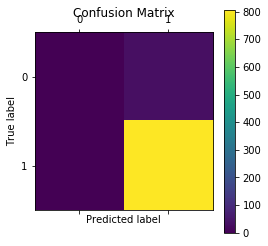

In [50]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_train, y_train)
best = grid_dt.best_estimator_

best.fit(X_train, y_train)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_train, y_train)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# UNDERSAMPLING

### RandomUndersampling

In [51]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 75, 1: 75})


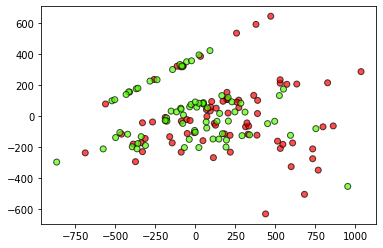

In [52]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.8s finished


Accuracy 0.7413587604290822
F1-score [0.14901961 0.84750527]
              precision    recall  f1-score   support

           0       0.09      0.59      0.15        32
           1       0.98      0.75      0.85       807

    accuracy                           0.74       839
   macro avg       0.53      0.67      0.50       839
weighted avg       0.94      0.74      0.82       839



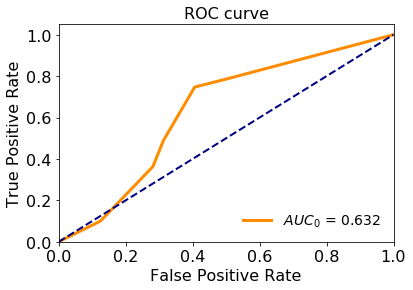

[[ 19  13]
 [204 603]]


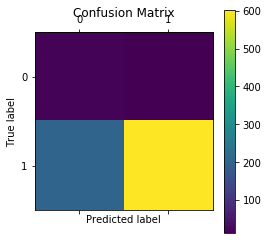





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    6.3s finished




Accuracy 0.7270560190703218
F1-score [0.12927757 0.83816254]
              precision    recall  f1-score   support

           0       0.07      0.53      0.13        32
           1       0.98      0.73      0.84       807

    accuracy                           0.73       839
   macro avg       0.52      0.63      0.48       839
weighted avg       0.94      0.73      0.81       839



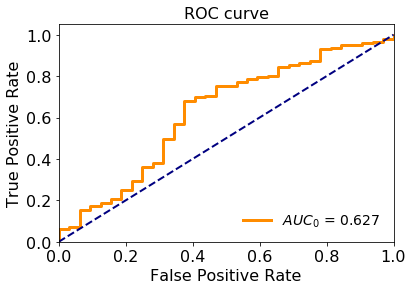

[[ 17  15]
 [214 593]]


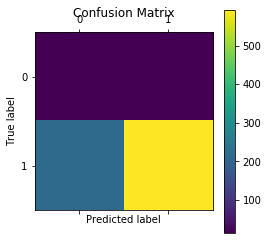

In [53]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### CondesedNearestNeighbour

In [54]:
cnn = CondensedNearestNeighbour(sampling_strategy = "not minority", random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 240, 0: 75})


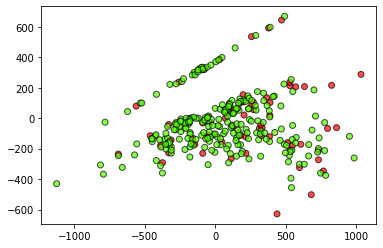

In [55]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

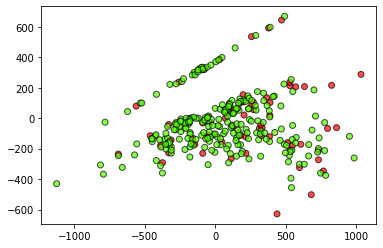

In [56]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 294 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.2s finished


Accuracy 0.9535160905840286
F1-score [0.04878049 0.97617593]
              precision    recall  f1-score   support

           0       0.11      0.03      0.05        32
           1       0.96      0.99      0.98       807

    accuracy                           0.95       839
   macro avg       0.54      0.51      0.51       839
weighted avg       0.93      0.95      0.94       839



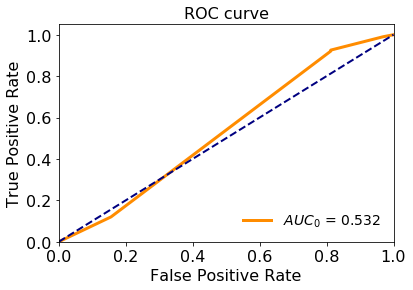

[[  1  31]
 [  8 799]]


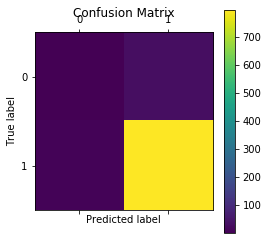





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   10.2s finished




Accuracy 0.9594755661501788
F1-score [0.         0.97931873]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.96      1.00      0.98       807

    accuracy                           0.96       839
   macro avg       0.48      0.50      0.49       839
weighted avg       0.93      0.96      0.94       839



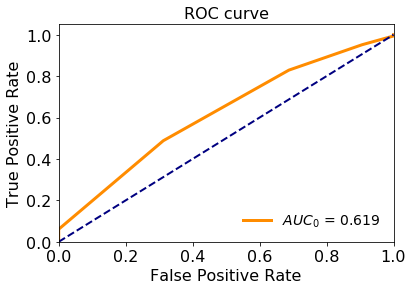

[[  0  32]
 [  2 805]]


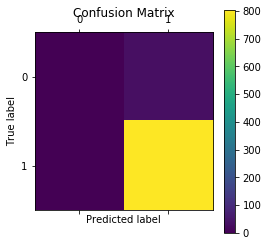

In [57]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Oversampling

### RandomOversampling

In [58]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 1881, 0: 1881})


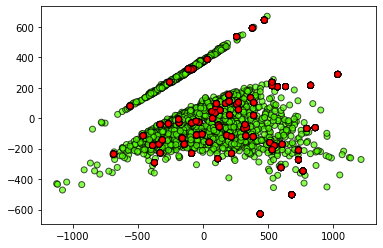

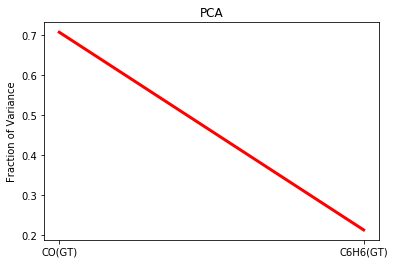

In [59]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()
plt.plot(pca.explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(2), df.columns)
plt.show()


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.4s finished


Accuracy 0.9129916567342073
F1-score [0.05194805 0.9544035 ]
              precision    recall  f1-score   support

           0       0.04      0.06      0.05        32
           1       0.96      0.95      0.95       807

    accuracy                           0.91       839
   macro avg       0.50      0.50      0.50       839
weighted avg       0.93      0.91      0.92       839



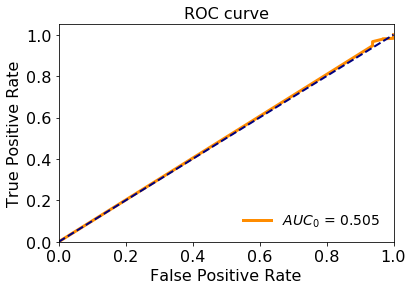

[[  2  30]
 [ 43 764]]


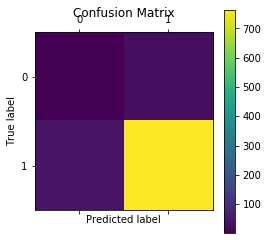





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   50.6s finished




Accuracy 0.933253873659118
F1-score [0.03448276 0.9654321 ]
              precision    recall  f1-score   support

           0       0.04      0.03      0.03        32
           1       0.96      0.97      0.97       807

    accuracy                           0.93       839
   macro avg       0.50      0.50      0.50       839
weighted avg       0.93      0.93      0.93       839



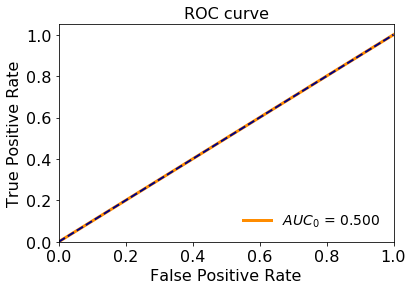

[[  1  31]
 [ 25 782]]


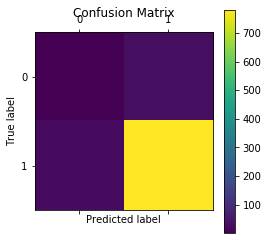

In [60]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## SMOTE

In [61]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 1881, 0: 1881})


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.3s finished


Accuracy 0.8390941597139452
F1-score [0.14012739 0.9112426 ]
              precision    recall  f1-score   support

           0       0.09      0.34      0.14        32
           1       0.97      0.86      0.91       807

    accuracy                           0.84       839
   macro avg       0.53      0.60      0.53       839
weighted avg       0.94      0.84      0.88       839



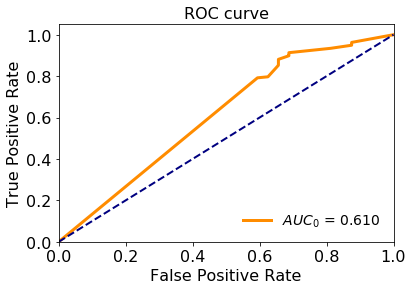

[[ 11  21]
 [114 693]]


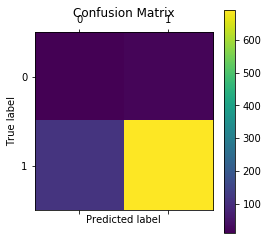





KNN




Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   44.3s finished




Accuracy 0.8474374255065554
F1-score [0.04477612 0.91709845]
              precision    recall  f1-score   support

           0       0.03      0.09      0.04        32
           1       0.96      0.88      0.92       807

    accuracy                           0.85       839
   macro avg       0.50      0.49      0.48       839
weighted avg       0.93      0.85      0.88       839



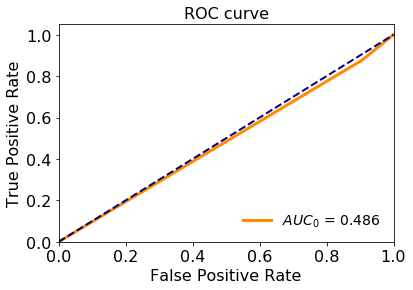

[[  3  29]
 [ 99 708]]


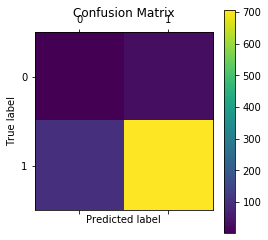

In [62]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_samples_leaf = [1,2,3]

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf }
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt.fit(X_res, y_res)
best = grid_dt.best_estimator_

best.fit(X_res, y_res)

y_pred0 = best.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))
y_score = best.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred0)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print("\n\n\n")
print("KNN")
print("\n\n\n")
knn = KNeighborsClassifier()
search = GridSearchCV(estimator = knn, param_grid = parameters,cv = 10, scoring = 'accuracy', verbose = 1, n_jobs = -1)
search.fit(X_res, y_res)
best_knn = search.best_estimator_

y_pred = best_knn.predict(X_test)

print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
y_score = best_knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()